In [5]:
### DAW Pipeline: Velo/Fuss + Meteo Swiss 
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid") 

### Configuration
PROJECT_PATH = os.getcwd()  # maybe better to use relative path
VELO_CSV = "converted_Velo_Fuss_Count.csv"  # in readme we should include websites and description of the datasets
METEO_CSV = "ogd-smn_bas_h_historical_2020-2029.csv"
METEO_META = "ogd-smn_meta_parameters.csv"
YEARS = [2024]   # Change here the year(s) you want to analyze
CHUNKSIZE = 500_000



print("\n\nAnalazing year(s):", YEARS, ", with chunk size for loading velo data:", CHUNKSIZE,"\n\n" )

### Step 1 — Load Meteo Data
def load_meteo_data(meteo_csv, meta_csv):
    """
    Load Meteo Swiss data and rename columns using metadata.

    Parameters
    ----------
    meteo_csv : str
        Path to the Meteo Swiss CSV file.
    meta_csv : str
        Path to the metadata CSV file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the Meteo Swiss data with renamed columns and parsed timestamps.
    """
    print("--> Loading Meteo Swiss data and metadata...\n")
    data = pd.read_csv(meteo_csv, sep=";", encoding="latin1")
    meta = pd.read_csv(meta_csv, sep=";", encoding="latin1")

    print("Original data preview:")
    display(data.head(3))
    print("Metadata preview:")
    display(meta.head(3))

    print("\nRenaming data columns using metadata...")
    rename_dict = dict(zip(meta["parameter_shortname"], meta["parameter_description_en"]))
    data = data.rename(columns=rename_dict)
    data["reference_timestamp"] = pd.to_datetime(
        data["reference_timestamp"], format="%d.%m.%Y %H:%M", dayfirst=True, errors="coerce"
    )

    print("\nFixed data preview:")
    display(data.head(3))
    return data



Analazing year(s): [2024] , with chunk size for loading velo data: 500000 




In [6]:
### Step 2 — Cleaning & Aggregation
def aggregate_daily_meteo(df, years):
    """
    Aggregate hourly Meteo Swiss data to daily level with summary statistics.

    Parameters
    ----------
    df : pd.DataFrame
        Meteo data with hourly timestamps.
    years : list of int
        List of years to include in the aggregation.

    Returns
    -------
    pd.DataFrame
        Daily aggregated Meteo Swiss data for Basel, including:
        - temp_mean_C : mean daily air temperature (°C)
        - precip_mm   : total daily precipitation (mm)
        - wind_mean_ms: mean daily wind speed (m/s)
    """
    print("\nAggregating Meteo Swiss data to daily level and calculating summary statistics...")

    hourly=df
    df = df[df["reference_timestamp"].dt.year.isin(years)]
    daily = (
        df.groupby(df["reference_timestamp"].dt.floor("D"))
        .agg(
            temp_mean_C=("Air temperature 2 m above ground; hourly mean", "mean"),
            precip_mm=("Precipitation; hourly total", "sum"),
            wind_mean_ms=("Wind speed scalar; hourly mean in m/s", "mean"),
        )
        .reset_index()
        .rename(columns={"reference_timestamp": "date"})
    )
    print("Daily Basel Meteo Swiss data (aggregated with mean/sum of key variables) preview:")
    display(daily.head(3))
    return daily ,hourly


def aggregate_velo_streaming(velo_csv, years, chunksize):
    """
    Stream large Velo/Fuss datasets and optionally aggregate daily totals.

    Returns
    -------
    tuple of pd.DataFrame
        - daily_result: daily aggregated data
        - hourly_result: non-aggregated hourly data
    """

    print("\n\n\n--> Loading Velo/Fuss data (streaming mode)...\n")
    print("Aggregating daily totals while streaming...\n")

    usecols = ["Date", "SiteCode", "SiteName", "Total"]
    usecols2 = ["Date", "TimeFrom", "SiteCode", "SiteName", "Total"]

    daily_agg = []
    raw_data = []
    hourly_data = []

    chunk_count = 0

    # -----------------------------
    # FIRST PASS (Daily Aggregation)
    # -----------------------------
    for chunk in pd.read_csv(
            velo_csv, sep=";", encoding="latin1", usecols=usecols,
            chunksize=chunksize, low_memory=False):

        chunk_count += 1

        chunk["Date"] = pd.to_datetime(chunk["Date"], errors="coerce", dayfirst=True)
        chunk = chunk.dropna(subset=["Date"])
        chunk = chunk[chunk["Date"].dt.year.isin(years)]

        if chunk.empty:
            continue

        daily = (
            chunk.groupby(["SiteCode", "SiteName", chunk["Date"].dt.floor("D")])["Total"]
            .sum()
            .reset_index()
        )
        daily_agg.append(daily)

    # Daily result after all chunks
    daily_result = pd.concat(daily_agg, ignore_index=True)
    daily_result = daily_result.rename(columns={"Date": "date", "Total": "daily_total"})

    # -----------------------------
    # SECOND PASS (Hourly)
    # -----------------------------
    # NOTE: this must be a separate loop because of different usecols
    for chunk in pd.read_csv(
            velo_csv, sep=";", encoding="latin1", usecols=usecols2,
            chunksize=chunksize, low_memory=False):

        chunk["Date"] = pd.to_datetime(chunk["Date"], errors="coerce", dayfirst=True)
        chunk = chunk.dropna(subset=["Date"])
        chunk = chunk[chunk["Date"].dt.year.isin(years)]

        if chunk.empty:
            continue

        # Combine Date + TimeFrom into hourly datetime
        chunk["hour"] = pd.to_datetime(
            chunk["Date"].dt.strftime("%Y-%m-%d") + " " + chunk["TimeFrom"].astype(str),
            errors="coerce"
        )
        chunk = chunk.dropna(subset=["hour"])

        # Save hourly (non-aggregated)
        hourly_data.append(
            chunk[["hour", "SiteCode", "SiteName", "Total"]].copy()
        )

        # Save raw data
        raw_data.append(chunk.copy())

    # Combine hourly & raw
    hourly_result = pd.concat(hourly_data, ignore_index=True)
    raw_result = pd.concat(raw_data, ignore_index=True)

    print(f"Finished processing {chunk_count} chunks.")
    print("Daily Velo/Fuss data (aggregated) preview:")
    display(daily_result.head(3))

    print("\nRaw (non-aggregated) hourly data preview:")
    display(hourly_result.head(3))

    return daily_result, hourly_result



def check_missing_days(df, col="date", years=YEARS):
    """
    Check for missing calendar days in a given dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing a datetime column.
    col : str, optional
        Name of the datetime column (default: 'date').
    years : list of int, optional
        Years to check for missing days.

    Returns
    -------
    dict
        Dictionary mapping each year to the count of missing days.
    """
    return {
        y: len(pd.date_range(f"{y}-01-01", f"{y}-12-31").difference(df[df[col].dt.year == y][col]))
        for y in years
    }


### Step 3 — Merge Datasets
def merge_datasets(daily_velo, daily_meteo):
    """
    Merge Velo/Fuss and Meteo datasets on the 'date' column.

    Parameters
    ----------
    daily_velo : pd.DataFrame
        Daily aggregated Velo/Fuss data.
    daily_meteo : pd.DataFrame
        Daily aggregated Meteo Swiss data.

    Returns
    -------
    pd.DataFrame
        Merged dataset containing traffic counts and meteorological variables.
    """
    print("\n\nMerging Velo/Fuss and Meteo datasets...")
    daily_velo["date"] = pd.to_datetime(daily_velo["date"])
    daily_meteo["date"] = pd.to_datetime(daily_meteo["date"])
    merged = pd.merge(daily_velo, daily_meteo, on="date", how="left")
    print(f"Merged dataset shape: {merged.shape}")
    print("\nMerged dataset preview:")
    display(merged.head(3))
    return merged


def merge_datasets2(hourly_velo, hourly_meteo):
    """
    Merge Velo/Fuss and Meteo datasets on the 'date' column.

    Parameters
    ----------
    daily_velo : pd.DataFrame
        Daily aggregated Velo/Fuss data.
    daily_meteo : pd.DataFrame
        Daily aggregated Meteo Swiss data.

    Returns
    -------
    pd.DataFrame
        Merged dataset containing traffic counts and meteorological variables.
    """
    print("\n\nMerging2 Velo/Fuss and Meteo datasets...")
    display(hourly_meteo.head())
    display(hourly_velo.head())
    #hourly_velo["date"] = pd.to_datetime(hourly_velo["date"])
    display(hourly_velo.head())
    try:
        hourly_meteo["reference_timestamp"] = pd.to_datetime(hourly_meteo["reference_timestamp"])
    except KeyError:
        display(hourly_meteo.head())
    hourly_meteo=hourly_meteo.rename(columns={"reference_timestamp":"hour"})
    merged2 = pd.merge(hourly_velo, hourly_meteo, on="hour", how="left")
    print(f"Merged dataset shape: {merged2.shape}")
    print("\nMerged dataset preview:")
    print("Merge hourly")
    display(merged2.head(3))
    return merged2


def plot_weekly_bar(merged_df, years):
    """Weekly bar plots of total counts per year."""
    print("\n\nGenerating weekly bar charts...")
    for year in years:
        df_year = merged_df[merged_df["date"].dt.year == year]
        weekly = (
            df_year.groupby(df_year["date"].dt.to_period("W"))["daily_total"]
            .sum()
            .reset_index()
        )
        weekly["week_start"] = weekly["date"].dt.start_time
        tick_idx = np.arange(0, len(weekly), 4)
        plt.figure(figsize=(12, 4))
        sns.barplot(data=weekly, x="week_start", y="daily_total", color="steelblue")
        plt.title(f"Weekly Total Velo/Fuss Counts ({year})")
        plt.xlabel("Week Start Date"); plt.ylabel("Total Counts")
        plt.xticks(
            tick_idx,
            weekly["week_start"].dt.strftime("%Y-%m-%d")[tick_idx],
            rotation=45,
        )
        plt.tight_layout(); plt.show()


def plot_scatter_trends(merged_df, cols):
    """Scatterplots of daily_total vs meteorological variables with linear trend."""
    print("\n\nGenerating scatterplots with linear trends...")
    for col in cols:
        x = merged_df[col].values
        y = merged_df["daily_total"].values
        coeffs = np.polyfit(x, y, 1)
        linear_func = np.poly1d(coeffs)
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=x, y=y, alpha=0.5)
        plt.plot(np.sort(x), linear_func(np.sort(x)), color="red")
        plt.title(f"Daily Total Velo/Fuss vs {col} (Linear Fit)")
        plt.xlabel(col); plt.ylabel("Daily Total")
        plt.tight_layout()
        plt.show()

--> Loading Meteo Swiss data and metadata...

Original data preview:


,station_abbr,reference_timestamp,tre200h0,tre200hn,tre200hx,tre005h0,tre005hn,ure200h0,pva200h0,tde200h0,...,fve010h0,rre150h0,htoauths,gre000h0,oli000h0,olo000h0,osr000h0,ods000h0,sre000h0,erefaoh0
0,BAS,01.01.2020 00:00,-0.8,-1.1,-0.6,-1.3,-1.9,93.9,5.4,-1.6,...,NaN,0.0,NaN,0,286.0,NaN,NaN,1.0,0,0.001
1,BAS,01.01.2020 01:00,-1.4,-2.3,-0.9,-3.4,-4.8,92.9,5.2,-2.4,...,NaN,0.0,NaN,0,229.0,NaN,NaN,1.0,0,-0.005
2,BAS,01.01.2020 02:00,-1.6,-2.1,-1.0,-5.1,-5.8,91.8,5.0,-2.7,...,NaN,0.0,NaN,0,225.0,NaN,NaN,1.0,0,-0.015


Metadata preview:


,parameter_shortname,parameter_description_de,parameter_description_fr,parameter_description_it,parameter_description_en,parameter_group_de,parameter_group_fr,parameter_group_it,parameter_group_en,parameter_granularity,parameter_decimals,parameter_datatype,parameter_unit
0,dkl010d0,Windrichtung; Tagesmittel,Direction du vent; moyenne journalière,Direzione del vento; media giornaliera,Wind direction; daily mean,Wind,Vent,Vento,Wind,D,0,Integer,°
1,dkl010h0,Windrichtung; Stundenmittel,Direction du vent; moyenne horaire,Direzione del vento; media oraria,Wind direction; hourly mean,Wind,Vent,Vento,Wind,H,0,Integer,°
2,dkl010z0,Windrichtung; Zehnminutenmittel,Direction du vent; moyenne sur 10 minutes,Direzione del vento; media su 10',Wind direction; ten minutes mean,Wind,Vent,Vento,Wind,T,0,Integer,°



Renaming data columns using metadata...

Fixed data preview:


,station_abbr,reference_timestamp,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,Relative air humidity 2 m above ground; hourly mean,Vapour pressure 2 m above ground; hourly mean,Dew point 2 m above ground; hourly mean,...,Wind speed vectorial; hourly mean in m/s,Precipitation; hourly total,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total
0,BAS,2020-01-01 00:00:00,-0.8,-1.1,-0.6,-1.3,-1.9,93.9,5.4,-1.6,...,NaN,0.0,NaN,0,286.0,NaN,NaN,1.0,0,0.001
1,BAS,2020-01-01 01:00:00,-1.4,-2.3,-0.9,-3.4,-4.8,92.9,5.2,-2.4,...,NaN,0.0,NaN,0,229.0,NaN,NaN,1.0,0,-0.005
2,BAS,2020-01-01 02:00:00,-1.6,-2.1,-1.0,-5.1,-5.8,91.8,5.0,-2.7,...,NaN,0.0,NaN,0,225.0,NaN,NaN,1.0,0,-0.015



Aggregating Meteo Swiss data to daily level and calculating summary statistics...
Daily Basel Meteo Swiss data (aggregated with mean/sum of key variables) preview:


,date,temp_mean_C,precip_mm,wind_mean_ms
0,2024-01-01,6.3000,1.7,2.820833
1,2024-01-02,8.6625,8.4,5.141667
2,2024-01-03,11.2375,3.9,6.758333





--> Loading Velo/Fuss data (streaming mode)...

Aggregating daily totals while streaming...

Finished processing 16 chunks.
Daily Velo/Fuss data (aggregated) preview:


,SiteCode,SiteName,date,daily_total
0,350,350 DreirosenbrÃ¼cke,2024-01-01,1825
1,350,350 DreirosenbrÃ¼cke,2024-01-02,2166
2,350,350 DreirosenbrÃ¼cke,2024-01-03,3379



Raw (non-aggregated) hourly data preview:


,hour,SiteCode,SiteName,Total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26




Checking missing days in both datasets:
Meteo Swiss: {2024: 0}
Velo/Fuss: {2024: 0}
comparte hourly


,hour,SiteCode,SiteName,Total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26




Merging Velo/Fuss and Meteo datasets...
Merged dataset shape: (16539, 7)

Merged dataset preview:


,SiteCode,SiteName,date,daily_total,temp_mean_C,precip_mm,wind_mean_ms
0,350,350 DreirosenbrÃ¼cke,2024-01-01,1825,6.3000,1.7,2.820833
1,350,350 DreirosenbrÃ¼cke,2024-01-02,2166,8.6625,8.4,5.141667
2,350,350 DreirosenbrÃ¼cke,2024-01-03,3379,11.2375,3.9,6.758333




Merging2 Velo/Fuss and Meteo datasets...


,station_abbr,reference_timestamp,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,Relative air humidity 2 m above ground; hourly mean,Vapour pressure 2 m above ground; hourly mean,Dew point 2 m above ground; hourly mean,...,Wind speed vectorial; hourly mean in m/s,Precipitation; hourly total,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total
0,BAS,2020-01-01 00:00:00,-0.8,-1.1,-0.6,-1.3,-1.9,93.9,5.4,-1.6,...,NaN,0.0,NaN,0,286.0,NaN,NaN,1.0,0,0.001
1,BAS,2020-01-01 01:00:00,-1.4,-2.3,-0.9,-3.4,-4.8,92.9,5.2,-2.4,...,NaN,0.0,NaN,0,229.0,NaN,NaN,1.0,0,-0.005
2,BAS,2020-01-01 02:00:00,-1.6,-2.1,-1.0,-5.1,-5.8,91.8,5.0,-2.7,...,NaN,0.0,NaN,0,225.0,NaN,NaN,1.0,0,-0.015
3,BAS,2020-01-01 03:00:00,-1.5,-1.7,-1.3,-3.9,-4.5,91.8,5.0,-2.6,...,NaN,0.0,NaN,0,224.0,NaN,NaN,1.0,0,-0.010
4,BAS,2020-01-01 04:00:00,-1.7,-1.8,-1.5,-3.8,-4.2,92.5,5.0,-2.7,...,NaN,0.0,NaN,0,223.0,NaN,NaN,1.0,0,-0.010


,hour,SiteCode,SiteName,Total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26
3,2024-01-01 03:00:00,350,350 DreirosenbrÃ¼cke,30
4,2024-01-01 04:00:00,350,350 DreirosenbrÃ¼cke,13


,hour,SiteCode,SiteName,Total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26
3,2024-01-01 03:00:00,350,350 DreirosenbrÃ¼cke,30
4,2024-01-01 04:00:00,350,350 DreirosenbrÃ¼cke,13


Merged dataset shape: (638400, 36)

Merged dataset preview:
Merge hourly


,hour,SiteCode,SiteName,Total,station_abbr,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,...,Wind speed vectorial; hourly mean in m/s,Precipitation; hourly total,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31,BAS,5.5,4.7,6.4,2.0,0.6,...,NaN,0.0,0.0,0,269.0,NaN,NaN,1.0,0,0.010
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43,BAS,6.6,6.4,6.9,5.3,5.0,...,NaN,0.0,0.0,0,304.0,NaN,NaN,1.0,0,0.025
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26,BAS,5.7,5.3,6.4,4.2,3.6,...,NaN,1.4,0.0,0,321.0,NaN,NaN,2.0,0,0.012




Generating weekly bar charts...


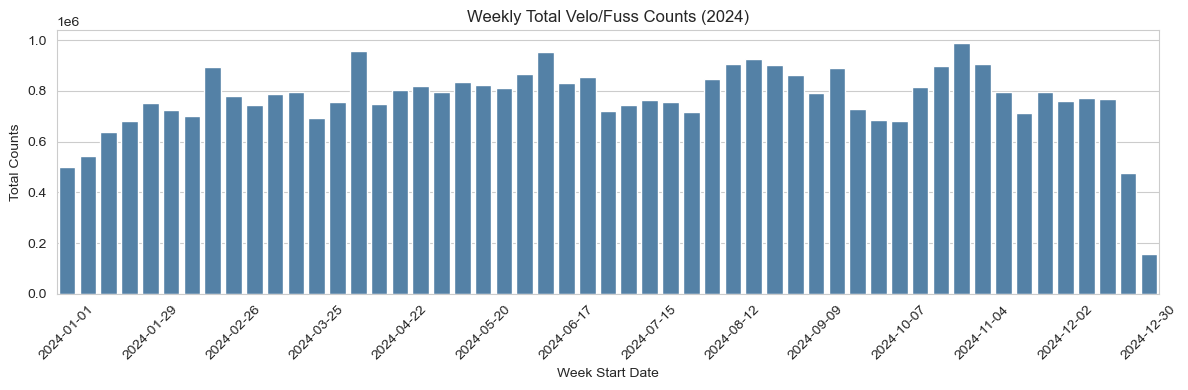



Generating scatterplots with linear trends...


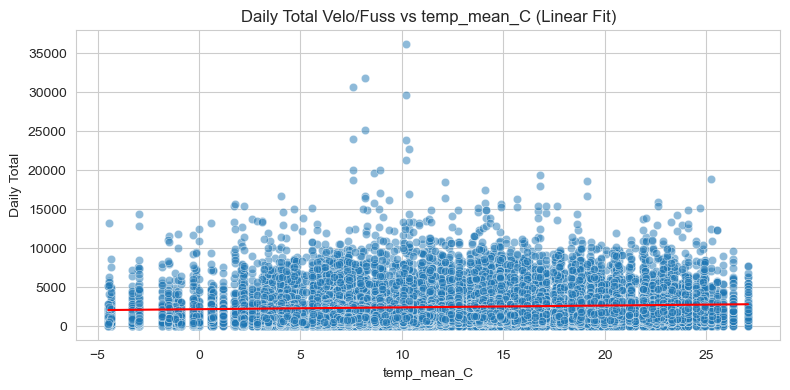

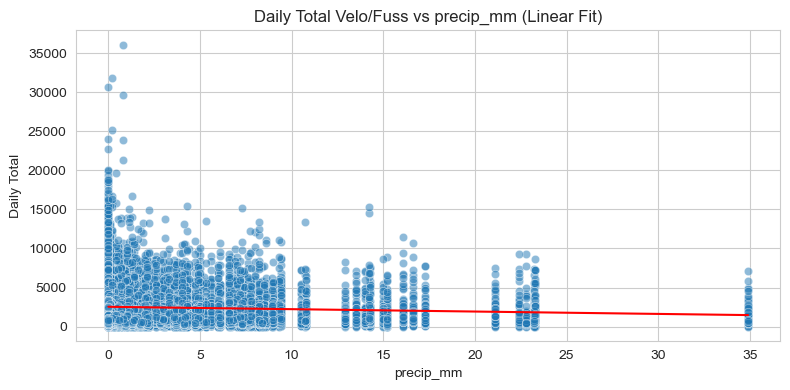

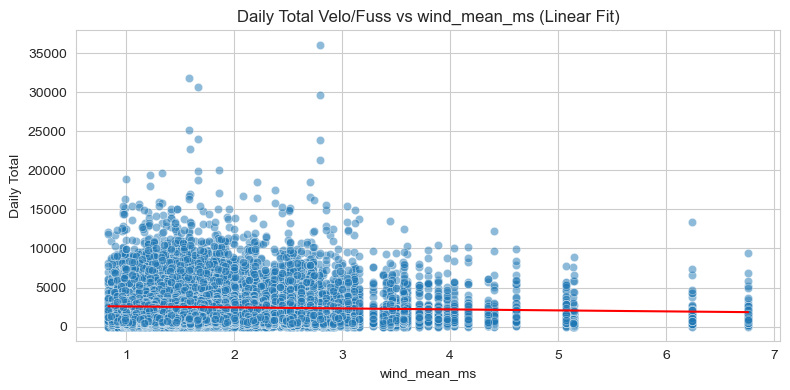


Merged dataset saved as 'merged_dataset.csv'.


,SiteCode,SiteName,date,daily_total,temp_mean_C,precip_mm,wind_mean_ms
0,350,350 DreirosenbrÃ¼cke,2024-01-01,1825,6.300000,1.7,2.820833
1,350,350 DreirosenbrÃ¼cke,2024-01-02,2166,8.662500,8.4,5.141667
2,350,350 DreirosenbrÃ¼cke,2024-01-03,3379,11.237500,3.9,6.758333
3,350,350 DreirosenbrÃ¼cke,2024-01-04,3636,8.108333,0.5,3.495833
4,350,350 DreirosenbrÃ¼cke,2024-01-05,3344,5.558333,1.4,1.741667


,hour,SiteCode,SiteName,Total,station_abbr,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,...,Wind speed vectorial; hourly mean in m/s,Precipitation; hourly total,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31,BAS,5.5,4.7,6.4,2.0,0.6,...,NaN,0.0,0.0,0,269.0,NaN,NaN,1.0,0,0.010
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43,BAS,6.6,6.4,6.9,5.3,5.0,...,NaN,0.0,0.0,0,304.0,NaN,NaN,1.0,0,0.025
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26,BAS,5.7,5.3,6.4,4.2,3.6,...,NaN,1.4,0.0,0,321.0,NaN,NaN,2.0,0,0.012
3,2024-01-01 03:00:00,350,350 DreirosenbrÃ¼cke,30,BAS,5.7,5.3,6.1,3.7,3.3,...,NaN,0.0,0.0,0,298.0,NaN,NaN,1.0,0,0.014
4,2024-01-01 04:00:00,350,350 DreirosenbrÃ¼cke,13,BAS,5.7,5.3,6.0,3.2,2.6,...,NaN,0.0,0.0,0,286.0,NaN,NaN,1.0,0,0.013


In [7]:
### Step 4 — Run Full Pipeline
def run_pipeline():
    """
    Execute the full DAW pipeline for Velo/Fuss and Meteo Swiss datasets.

    Returns
    -------
    pd.DataFrame
        Merged dataset with daily totals and meteorological variables.
    """
    meteo_raw = load_meteo_data(METEO_CSV, METEO_META) # Loads load_meteo_data function
    daily_meteo, hourly_meteo = aggregate_daily_meteo(meteo_raw, YEARS) # Loads aggregate_daily_meteo function

    daily_velo, hourly_velo,  = aggregate_velo_streaming(VELO_CSV, YEARS, CHUNKSIZE) # Loads aggregate_velo_streaming function

    print("\n\nChecking missing days in both datasets:")
    print("Meteo Swiss:", check_missing_days(daily_meteo))
    print("Velo/Fuss:", check_missing_days(daily_velo))

    print("comparte hourly")
    display(hourly_velo.head(3))

    merged = merge_datasets(daily_velo, daily_meteo)
    merged2=merge_datasets2(hourly_velo, hourly_meteo)

    plot_weekly_bar(merged, YEARS)
    plot_scatter_trends(merged, ["temp_mean_C", "precip_mm", "wind_mean_ms"])

    # Save final dataset for reproducibility
    merged.to_csv("merged_dataset.csv", index=False)
    print("\nMerged dataset saved as 'merged_dataset.csv'.")

    return merged, merged2


# Run full pipeline
merged_df,merged_df_hourly = run_pipeline()
display(merged_df.head())
display(merged_df_hourly.head())

In [3]:
    #os.chdir(PROJECT_PATH)
    print(f"Working directory: {os.getcwd()}")

Working directory: C:\FHNW\DAW\JupyterProject1


,SiteCode,SiteName,date,daily_total,temp_mean_C,precip_mm,wind_mean_ms,month
0,350,350 DreirosenbrÃ¼cke,2024-01-01,1825,6.3000,1.7,2.820833,1
1,350,350 DreirosenbrÃ¼cke,2024-01-02,2166,8.6625,8.4,5.141667,1
2,350,350 DreirosenbrÃ¼cke,2024-01-03,3379,11.2375,3.9,6.758333,1


dataframe with seasons


,SiteCode,SiteName,date,daily_total,temp_mean_C,precip_mm,wind_mean_ms,month,season
0,350,350 DreirosenbrÃ¼cke,2024-01-01,1825,6.3000,1.7,2.820833,1,winter
1,350,350 DreirosenbrÃ¼cke,2024-01-02,2166,8.6625,8.4,5.141667,1,winter
2,350,350 DreirosenbrÃ¼cke,2024-01-03,3379,11.2375,3.9,6.758333,1,winter


η = 0.02839322862957647


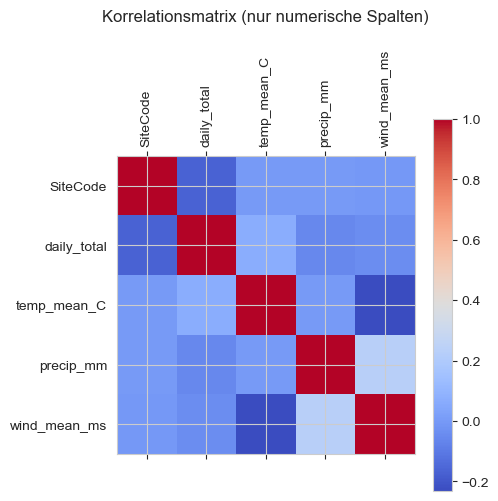

In [8]:

numeric_df = merged_df.select_dtypes(include=['number'])
corr = numeric_df.corr()

# Plot anzeigen
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.title("Korrelationsmatrix (nur numerische Spalten)", pad=20)

# Achsenbeschriftung mit Spaltennamen
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

#calculate new variables
merged_df["month"]=merged_df["date"].dt.month
display(merged_df.head(3))



def season(month):
    if 3 <= month < 5:
        return 'spring'
    elif 6 <= month < 8:
        return 'summer'
    elif 9 <= month < 12:
        return 'autumn'
    else:
        return 'winter'

merged_df["season"] = merged_df["month"].apply(season)
print("dataframe with seasons")
display(merged_df.head(3))

import numpy as np
import pandas as pd

def eta_squared(df, categorical_col, continuous_col):
    categories = df[categorical_col].unique()
    grand_mean = df[continuous_col].mean()
    ss_between = sum([
        len(df[df[categorical_col] == cat]) * (df[df[categorical_col] == cat][continuous_col].mean() - grand_mean)**2
        for cat in categories
    ])
    ss_total = sum((df[continuous_col] - grand_mean)**2)
    eta = np.sqrt(ss_between / ss_total)
    return eta

eta = eta_squared(merged_df, "season", "daily_total")
print("η =", eta)#there is no correlation between season and total, maybe compare seasons of different years

In [11]:
print("η =", eta)

η = 0.02839322862957647


       SiteCode                   SiteName       date  daily_total  \
0           350       350 DreirosenbrÃ¼cke 2024-01-01         1825   
1           350       350 DreirosenbrÃ¼cke 2024-01-02         2166   
2           350       350 DreirosenbrÃ¼cke 2024-01-03         3379   
3           350       350 DreirosenbrÃ¼cke 2024-01-04         3636   
4           350       350 DreirosenbrÃ¼cke 2024-01-05         3344   
...         ...                        ...        ...          ...   
16534       920  920 J. Burckhardt-Strasse 2024-02-25          478   
16535       920  920 J. Burckhardt-Strasse 2024-02-26          850   
16536       920  920 J. Burckhardt-Strasse 2024-02-27          806   
16537       920  920 J. Burckhardt-Strasse 2024-02-28          747   
16538       920  920 J. Burckhardt-Strasse 2024-02-29          834   

       temp_mean_C  precip_mm  wind_mean_ms  month  season  
0         6.300000        1.7      2.820833      1  winter  
1         8.662500        8.4      5.

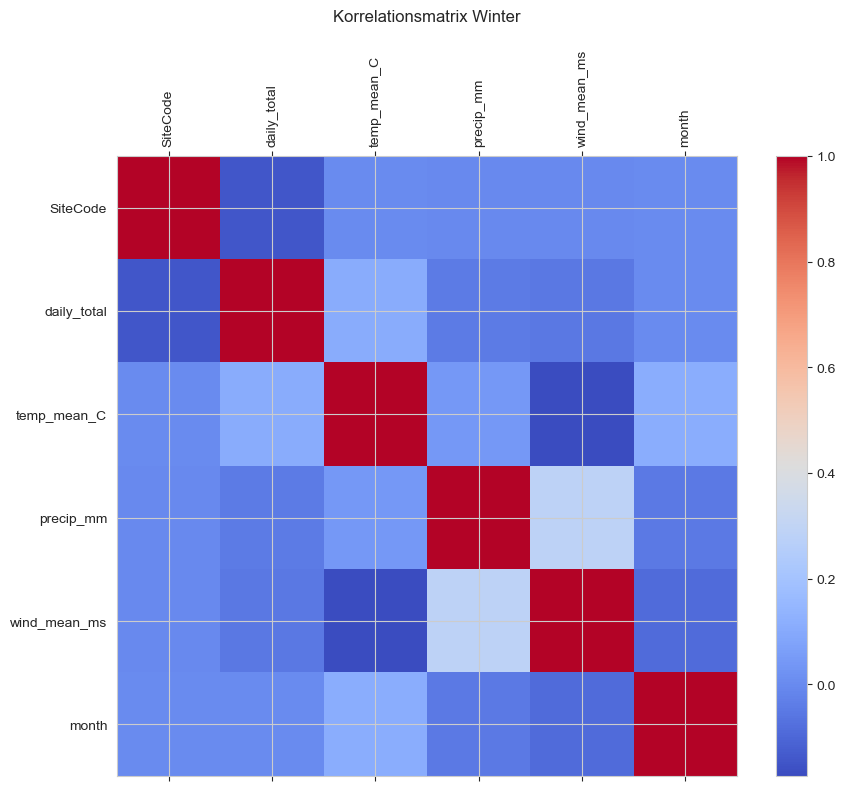

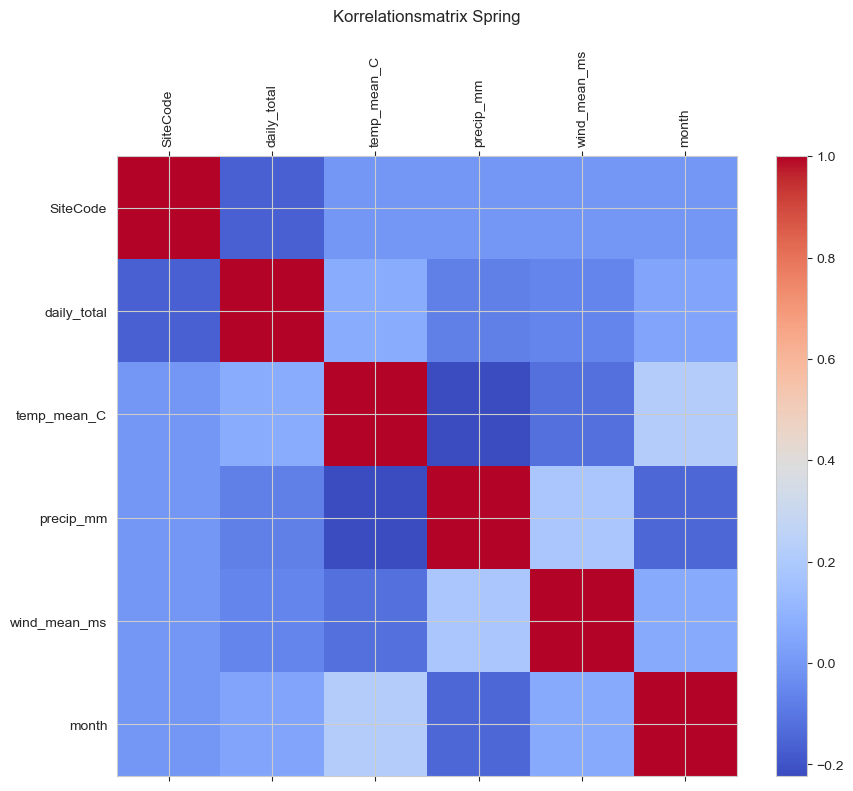

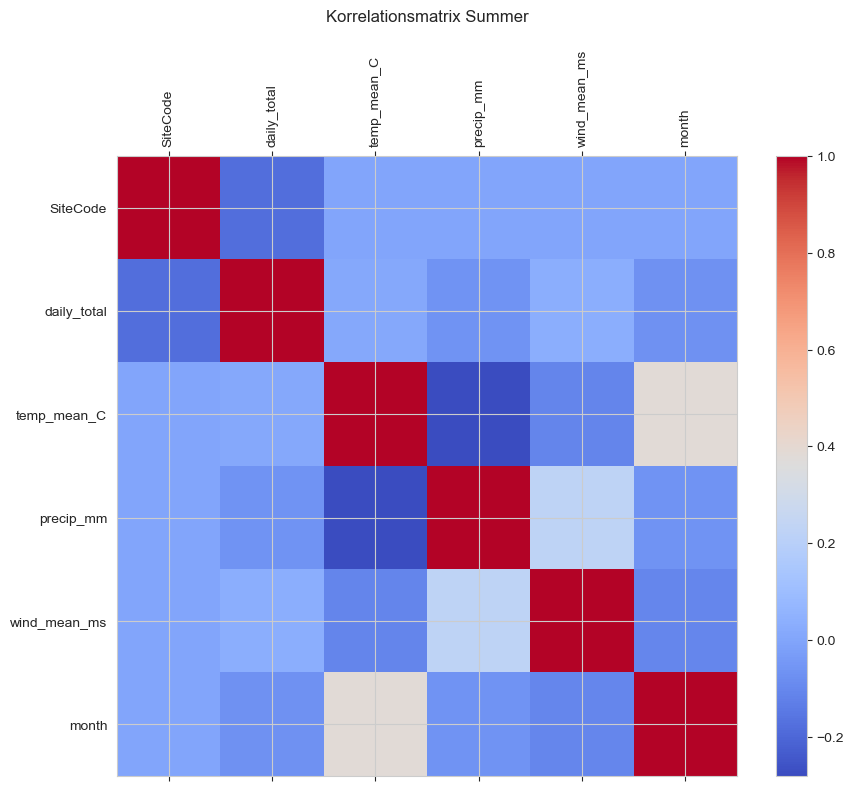

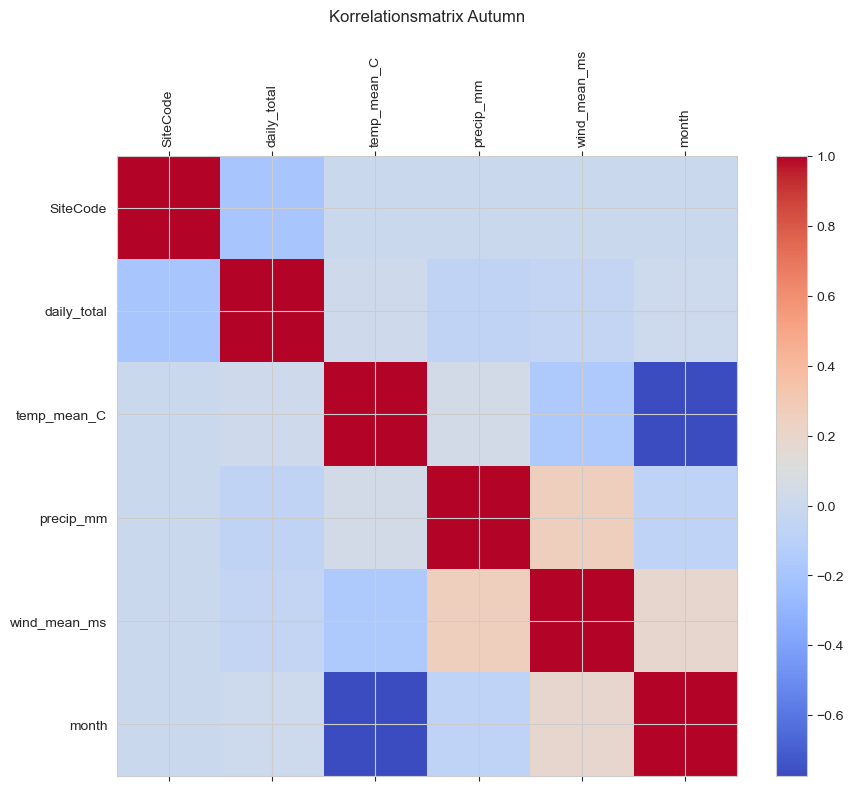

,Winter,Frühling,Sommer,Herbst
SiteCode,-2.115532,-2.306553,-2.485279,-2.695617
temp_mean_C,33.750092,29.241861,18.557467,29.624947
precip_mm,-23.854603,-38.547917,-39.939028,-24.597064
wind_mean_ms,-63.737230,-133.739216,285.614754,-90.779475
month,-7.608051,165.071321,-375.935967,172.629408


C:\Users\famil\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


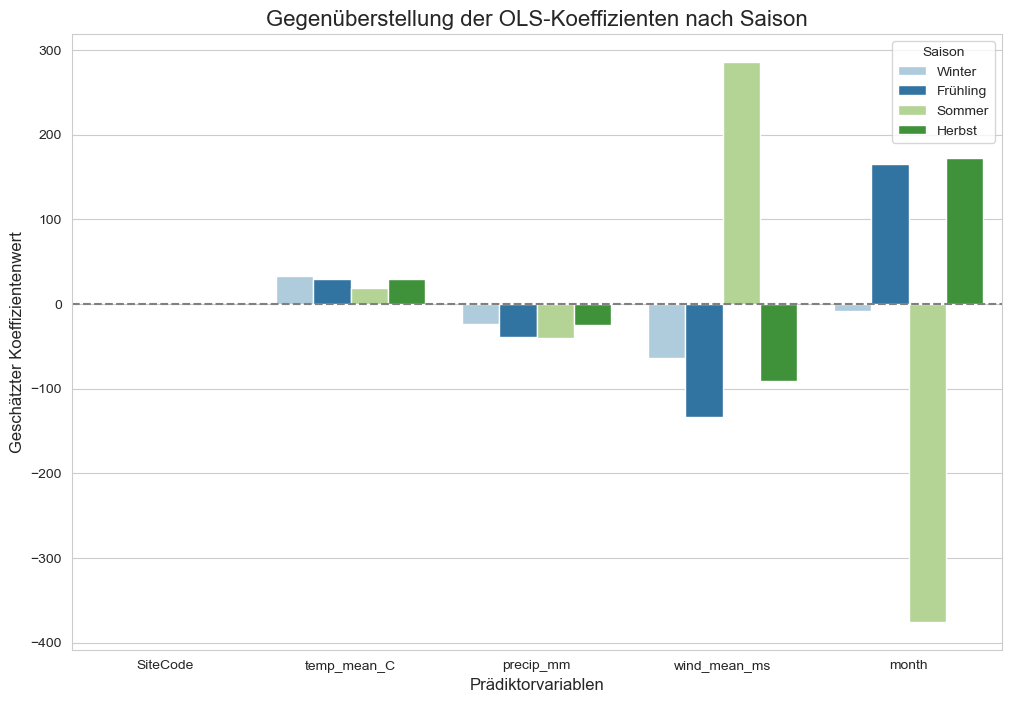

In [26]:
print(merged_df)
def select_numeric(df):
    return df.select_dtypes(include=['number'])

# Winter
winter_df = merged_df[merged_df['season'].str.contains('winter', case=False, na=False)]
winter_df = select_numeric(winter_df)

# Summer
summer_df = merged_df[merged_df['season'].str.contains('summer', case=False, na=False)]
summer_df = select_numeric(summer_df)

# Spring
spring_df = merged_df[merged_df['season'].str.contains('spring', case=False, na=False)]
spring_df = select_numeric(spring_df)

# Autumn
autumn_df = merged_df[merged_df['season'].str.contains('autumn', case=False, na=False)]
autumn_df = select_numeric(autumn_df)

# Korrelation
corrs = {
    "Winter": winter_df.corr(),
    "Spring": spring_df.corr(),
    "Summer": summer_df.corr(),
    "Autumn": autumn_df.corr()
}

for season, corr in corrs.items():
    plt.figure(figsize=(10, 8))
    plt.matshow(corr, cmap='coolwarm', fignum=1)
    plt.colorbar()
    plt.title(f"Korrelationsmatrix {season}", pad=20)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

import statsmodels.api as sm
def models(list_df):
    all_params = []
    saison_namen = ["Winter", "Frühling", "Sommer", "Herbst"]
    i=-1
    for df in list_df:
        i=i+1
        # Zielvariable
        y = df["daily_total"]

        # Nur numerische Spalten als potenzielle Prädiktoren
        X = df.select_dtypes(include=["number"]).drop(columns=["daily_total"], errors="ignore")

        # Konstanten hinzufügen (Intercept)
        X = sm.add_constant(X)

        # Modell schätzen
        model = sm.OLS(y, X).fit()
        # Die Koeffizienten (`model.params`) als Pandas Series erhalten
        params = model.params

        params = params.drop("const", errors="ignore")

        # Die Series umbenennen, um die Saison im finalen DataFrame zu identifizieren
        params.name = saison_namen[i]
        #print(model.summary())
        #print(model.params)
        # Die Koeffizienten-Series der Liste hinzufügen
        all_params.append(params)

    # Alle gesammelten Series zu einem einzigen DataFrame kombinieren
    # axis=1 bedeutet, dass die Series als Spalten hinzugefügt werden
    results_df = pd.DataFrame(all_params).T # .T transponiert die Tabelle für bessere Lesbarkeit
    return results_df
    # Ausgabe der Tabelle


    # Ausgabe anzeigen
list_df=[winter_df,spring_df,summer_df, autumn_df]
result=models(list_df)
display(result)
def plot_coefficients(results_df):
    """
    Stellt die Koeffizienten des DataFrames als gruppiertes Balkendiagramm dar.
    """

    # Optional: Den Index ('const', 'temp', 'rain') in eine Spalte umwandeln
    # für die Verwendung in Seaborn
    plot_df = results_df.reset_index()
    plot_df = plot_df.rename(columns={'index': 'Prädiktor'})

    # Daten für Seaborn 'schmelzen' (melt), um sie ins "long format" zu bringen,
    # das ideal für gruppierte Balkendiagramme ist
    # Wir möchten die Saisons als Kategorien für die Gruppierung haben
    melted_df = plot_df.melt(id_vars='Prädiktor', var_name='Saison', value_name='Koeffizient')

    plt.figure(figsize=(12, 8))

    # Erstellen des gruppierten Balkendiagramms mit Seaborn
    # x = Prädiktor (z.B. temp, rain), hue = Saison (gruppiert nach Farbe)
    sns.barplot(x='Prädiktor', y='Koeffizient', hue='Saison', data=melted_df, palette="Paired")

    plt.title('Gegenüberstellung der OLS-Koeffizienten nach Saison', fontsize=16)
    plt.ylabel('Geschätzter Koeffizientenwert', fontsize=12)
    plt.xlabel('Prädiktorvariablen', fontsize=12)
    plt.legend(title='Saison', loc='upper right')

    # Zusätzliche Linie bei y=0 hinzufügen, um positive/negative Effekte klarer zu sehen
    plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Diagramm anzeigen
    plt.show()
result.iloc[0] = np.log(result.iloc[0])
plot_coefficients(result)

In [89]:
display(merged_df_hourly.head())
def prepare_hourly_datetime(df):
    """
    Nimmt einen DataFrame mit einer Spalte 'hour' (datetime) und:
    - benennt sie in 'date_time' um
    - extrahiert die Stunde (0–23)
    - klassifiziert die Tageszeit: Morgen, Nachmittag, Nacht
    """

    # Spalte 'hour' -> 'date_time'
    df = df.rename(columns={"hour": "date_time"})

    # Stunde extrahieren
    df["hour"] = df["date_time"].dt.hour

    # Funktion zur Tageszeit-Klassifikation
    def classify_time(h):
        if 5 <= h < 12:
            return "Morgen"
        elif 12 <= h < 18:
            return "Nachmittag"
        else:
            return "Nacht"

    df["tageszeit"] = df["hour"].apply(classify_time)

    return df

df=prepare_hourly_datetime(merged_df_hourly)
display(df.head())
print(df.columns)

,hour,SiteCode,SiteName,Total,station_abbr,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,...,Wind speed vectorial; hourly mean in m/s,Precipitation; hourly total,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31,BAS,5.5,4.7,6.4,2.0,0.6,...,NaN,0.0,0.0,0,269.0,NaN,NaN,1.0,0,0.010
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43,BAS,6.6,6.4,6.9,5.3,5.0,...,NaN,0.0,0.0,0,304.0,NaN,NaN,1.0,0,0.025
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26,BAS,5.7,5.3,6.4,4.2,3.6,...,NaN,1.4,0.0,0,321.0,NaN,NaN,2.0,0,0.012
3,2024-01-01 03:00:00,350,350 DreirosenbrÃ¼cke,30,BAS,5.7,5.3,6.1,3.7,3.3,...,NaN,0.0,0.0,0,298.0,NaN,NaN,1.0,0,0.014
4,2024-01-01 04:00:00,350,350 DreirosenbrÃ¼cke,13,BAS,5.7,5.3,6.0,3.2,2.6,...,NaN,0.0,0.0,0,286.0,NaN,NaN,1.0,0,0.013


,date_time,SiteCode,SiteName,Total,station_abbr,Air temperature 2 m above ground; hourly mean,Air temperature 2 m above ground; hourly minimum,Air temperature 2 m above ground; hourly maximum,Air temperature at 5 cm above grass; hourly mean,Air temperature at 5 cm above grass; hourly minimum,...,Snow depth (automatic measurement); hourly current value,Global radiation; hourly mean,Longwave incoming radiation; hourly mean,Longwave outgoing radiation; hourly mean,Shortwave reflected radiation; hourly mean,Diffuse radiation; hourly mean,Sunshine duration; hourly total,Reference evaporation from FAO; hourly total,hour,tageszeit
0,2024-01-01 00:00:00,350,350 DreirosenbrÃ¼cke,31,BAS,5.5,4.7,6.4,2.0,0.6,...,0.0,0,269.0,NaN,NaN,1.0,0,0.010,0,Nacht
1,2024-01-01 01:00:00,350,350 DreirosenbrÃ¼cke,43,BAS,6.6,6.4,6.9,5.3,5.0,...,0.0,0,304.0,NaN,NaN,1.0,0,0.025,1,Nacht
2,2024-01-01 02:00:00,350,350 DreirosenbrÃ¼cke,26,BAS,5.7,5.3,6.4,4.2,3.6,...,0.0,0,321.0,NaN,NaN,2.0,0,0.012,2,Nacht
3,2024-01-01 03:00:00,350,350 DreirosenbrÃ¼cke,30,BAS,5.7,5.3,6.1,3.7,3.3,...,0.0,0,298.0,NaN,NaN,1.0,0,0.014,3,Nacht
4,2024-01-01 04:00:00,350,350 DreirosenbrÃ¼cke,13,BAS,5.7,5.3,6.0,3.2,2.6,...,0.0,0,286.0,NaN,NaN,1.0,0,0.013,4,Nacht


Index(['date_time', 'SiteCode', 'SiteName', 'Total', 'station_abbr',
       'Air temperature 2 m above ground; hourly mean',
       'Air temperature 2 m above ground; hourly minimum',
       'Air temperature 2 m above ground; hourly maximum',
       'Air temperature at 5 cm above grass; hourly mean',
       'Air temperature at 5 cm above grass; hourly minimum',
       'Relative air humidity 2 m above ground; hourly mean',
       'Vapour pressure 2 m above ground; hourly mean',
       'Dew point 2 m above ground; hourly mean',
       'Atmospheric pressure at barometric altitude (QFE); hourly mean',
       'Pressure reduced to sea level (QFF); hourly mean',
       'Pressure reduced to sea level according to standard atmosphere (QNH); hourly mean',
       'Geopotential height of the 700 hPA level; hourly mean',
       'Geopotential height of the 850 hPA level; hourly mean',
       'Gust peak (one second); hourly maximum in m/s',
       'Wind direction; hourly mean', 'Wind speed scalar; ho

In [92]:
selected_columns = [
    "date_time",
    #"SiteCode",
    #"SiteName",
    "hour",
    "tageszeit",
    "Total",                               # Zielvariable

    "Air temperature 2 m above ground; hourly mean",
    "Relative air humidity 2 m above ground; hourly mean",
    "Precipitation; hourly total",
    "Wind speed scalar; hourly mean in m/s",
    "Wind direction; hourly mean",
    "Global radiation; hourly mean",        # oder Sunshine duration
    "Snow depth (automatic measurement); hourly current value",
]
display(df[selected_columns].head())
df[selected_columns].corr


,date_time,hour,tageszeit,Total,Air temperature 2 m above ground; hourly mean,Relative air humidity 2 m above ground; hourly mean,Precipitation; hourly total,Wind speed scalar; hourly mean in m/s,Wind direction; hourly mean,Global radiation; hourly mean,Snow depth (automatic measurement); hourly current value
0,2024-01-01 00:00:00,0,Nacht,31,5.5,71.6,0.0,2.2,213.0,0,0.0
1,2024-01-01 01:00:00,1,Nacht,43,6.6,68.3,0.0,4.2,214.0,0,0.0
2,2024-01-01 02:00:00,2,Nacht,26,5.7,82.2,1.4,3.3,244.0,0,0.0
3,2024-01-01 03:00:00,3,Nacht,30,5.7,79.4,0.0,3.5,212.0,0,0.0
4,2024-01-01 04:00:00,4,Nacht,13,5.7,74.9,0.0,2.8,228.0,0,0.0


<bound method DataFrame.corr of                  date_time  hour tageszeit  Total  \
0      2024-01-01 00:00:00     0     Nacht     31   
1      2024-01-01 01:00:00     1     Nacht     43   
2      2024-01-01 02:00:00     2     Nacht     26   
3      2024-01-01 03:00:00     3     Nacht     30   
4      2024-01-01 04:00:00     4     Nacht     13   
...                    ...   ...       ...    ...   
638395 2024-02-29 19:00:00    19     Nacht      4   
638396 2024-02-29 20:00:00    20     Nacht      3   
638397 2024-02-29 21:00:00    21     Nacht      2   
638398 2024-02-29 22:00:00    22     Nacht      1   
638399 2024-02-29 23:00:00    23     Nacht      1   

        Air temperature 2 m above ground; hourly mean  \
0                                                 5.5   
1                                                 6.6   
2                                                 5.7   
3                                                 5.7   
4                                             